#Boosting Techniques
**Question 1**

What is Boosting in Machine Learning? Explain how it improves weak learners.

**Answer:** Boosting is an ensemble technique that builds a strong learner by sequentially combining many weak learners (models that perform just slightly better than random). Each new model focuses on examples the previous models struggled with, typically by reweighting samples (e.g., AdaBoost) or by fitting residual errors/gradients (e.g., Gradient Boosting). Final predictions are a weighted vote (classification) or sum (regression) of all weak learners.

Why it improves weak learners:

- Focus on hard cases: Misclassified or high-error samples get more attention in later rounds.

- Bias reduction: Sequential corrections reduce systematic errors.

- Additive modeling: Each learner adds a small, targeted improvement.

- Shrinkage & regularization: Learning rate, depth constraints, and penalties curb overfitting while allowing many learners to contribute.

**Question 2**

What is the difference between AdaBoost and Gradient Boosting in terms of how models are trained?

**Answer:**
| Aspect                 | **AdaBoost**                                                                         | **Gradient Boosting**                                                                     |
| ---------------------- | ------------------------------------------------------------------------------------ | ----------------------------------------------------------------------------------------- |
| **Core idea**          | Reweights misclassified samples and builds next learner on updated weights.          | Fits new learners to the **residuals (negative gradients)** of the chosen loss function.  |
| **Error handling**     | Increases weights of wrongly classified samples so the next learner focuses on them. | Each learner directly minimizes the gradient of the loss (e.g., squared error, log loss). |
| **Loss function**      | Implicitly based on **exponential loss** (for classification).                       | Works with any **differentiable loss** (squared error, log loss, MAE, etc.).              |
| **Base learners**      | Often **decision stumps** (depth=1 trees).                                           | Typically **deeper trees** (depth 3–6) for capturing complex interactions.                |
| **Combination method** | Weighted majority vote (classification) or weighted sum (regression).                | Additive model: final prediction is the sum of all learners’ outputs.                     |
| **Flexibility**        | Less flexible (fixed exponential-style weighting).                                   | More flexible (supports custom loss, regularization, shrinkage).                          |
| **Interpretability**   | Simpler, fewer hyperparameters.                                                      | Richer, more complex, requires careful tuning.                                            |
| **Performance**        | Good for simpler tasks, small datasets.                                              | Superior for large, complex, noisy, or tabular datasets.                                  |


**Question 3**

How does regularization help in XGBoost?

**Answer:**
XGBoost adds multiple regularization mechanisms that reduce overfitting and improve generalization/performance:

- L1/L2 penalties (alpha, lambda) on leaf weights stabilize the model and control complexity.

- Tree constraints: max_depth, min_child_weight, gamma (min loss reduction for a split), and max_leaves limit tree growth.

- Shrinkage (learning_rate/eta): Small learning steps make each tree’s contribution modest, enabling more robust additive modeling.

- Subsampling: subsample (rows) and colsample_bytree/bylevel/bynode (features) act like built-in bagging to reduce variance.

- Early stopping: Halts training when validation performance stalls, preventing overfit.

Together, these mechanisms make XGBoost fast, accurate, and robust on noisy/tabular data.

**Question 4**

Why is CatBoost considered efficient for handling categorical data?

**Answer:**
CatBoost is designed for categorical features and avoids target leakage via ordered target statistics: it computes target-based encodings using permutation-driven, past-only statistics. Key advantages:

- Native categorical handling: No need for heavy one-hot encoding; reduces dimensionality.

- Ordered boosting: Mitigates prediction shift by using an ordering scheme for both boosting and statistics.

- Robust defaults: Handles missing values and categorical encodings internally with strong regularization.

- Fast, accurate on tabular data: Typically competitive out-of-the-box with minimal preprocessing.

**Question 5**

What are some real-world applications where boosting techniques are preferred over bagging methods?

**Answer:**
Boosting often wins on structured/tabular problems with heterogeneous features and complex interactions, especially when accuracy is paramount:

- Credit risk / fraud detection (imbalanced classification)

- Click-through rate (CTR) prediction / ad ranking

- Customer churn / propensity modeling

- Insurance pricing & claim prediction

- Medical diagnosis / readmission risk

- Demand forecasting / price elasticity

Reason: Boosting’s additive, gradient-driven corrections capture subtle patterns better than bagging’s pure variance reduction.

**Question 6**

Write a Python program to:

Train an AdaBoost Classifier on the Breast Cancer dataset

Print the model accuracy

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Load data
X, y = load_breast_cancer(return_X_y=True)

# Train/val split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Base learner: decision stump (depth=1) is classic for AdaBoost
base = DecisionTreeClassifier(max_depth=1, random_state=42)

# AdaBoost
clf = AdaBoostClassifier(
    estimator=base,        # or base_estimator in older sklearn
    n_estimators=200,
    learning_rate=0.5,
    random_state=42
)
clf.fit(X_train, y_train)

# Evaluate
pred = clf.predict(X_test)
acc = accuracy_score(y_test, pred)
print(f"AdaBoost test accuracy: {acc:.4f}")


AdaBoost test accuracy: 0.9561


**Question 7**

Write a Python program to:

Train a Gradient Boosting Regressor on the California Housing dataset

Evaluate performance using R-squared score

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd

# Load data
data = fetch_california_housing(as_frame=True)
X = data.frame.drop(columns=["MedHouseVal"])
y = data.frame["MedHouseVal"]

# (Optional) simple scaling for continuous features can help weak learners
num_features = list(X.columns)
pre = ColumnTransformer(
    transformers=[("num", StandardScaler(), num_features)],
    remainder="drop"
)

gbr = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    random_state=42
)

pipe = Pipeline([("pre", pre), ("model", gbr)])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(f"Gradient Boosting R^2: {r2_score(y_test, y_pred):.4f}")


Gradient Boosting R^2: 0.8077


**Question 8**

Write a Python program to:

Train an XGBoost Classifier on the Breast Cancer dataset

Tune the learning rate using GridSearchCV

Print the best parameters and accuracy

In [3]:
# !pip install xgboost  # Uncomment if running locally and xgboost is missing

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import numpy as np

# Data
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Base model
xgb = XGBClassifier(
    n_estimators=400,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

# Grid over learning_rate
param_grid = {"learning_rate": [0.01, 0.05, 0.1, 0.2]}

grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=0
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_
pred = best_model.predict(X_test)
acc = accuracy_score(y_test, pred)

print(f"Best params: {grid.best_params_}")
print(f"Test accuracy: {acc:.4f}")


Best params: {'learning_rate': 0.1}
Test accuracy: 0.9561


**Question 9**

Write a Python program to:

Train a CatBoost Classifier

Plot the confusion matrix using seaborn

In [5]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.7 MB/s eta 0:00:00


              precision    recall  f1-score   support

           0       0.97      0.93      0.95        42
           1       0.96      0.99      0.97        72

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



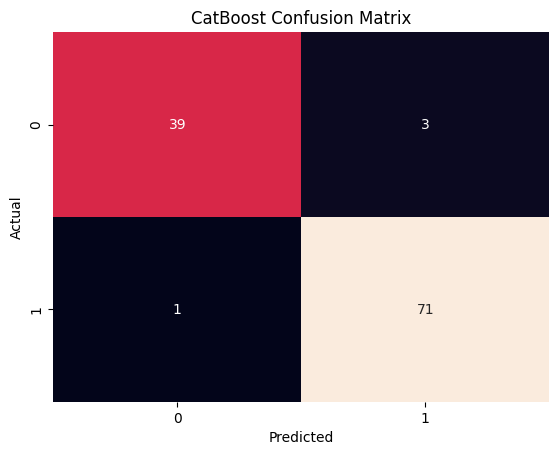

In [6]:
# Q9: CatBoost Classifier + Confusion Matrix
# !pip install catboost seaborn  # Uncomment if running locally

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from catboost import CatBoostClassifier, Pool
import seaborn as sns
import matplotlib.pyplot as plt

# Data
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# CatBoost (silent training)
cb = CatBoostClassifier(
    depth=6,
    learning_rate=0.1,
    iterations=400,
    loss_function="Logloss",
    random_seed=42,
    verbose=False
)
cb.fit(X_train, y_train)

# Predictions and confusion matrix
y_pred = cb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))

plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.title("CatBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**Question 10**

You're working for a FinTech company trying to predict loan default using customer demographics and transaction behavior.
The dataset is imbalanced, contains missing values, and has both numeric and categorical features.

Describe your step-by-step data science pipeline using boosting techniques:

Data preprocessing & handling missing/categorical values

Choice between AdaBoost, XGBoost, or CatBoost

Hyperparameter tuning strategy

Evaluation metrics you'd choose and why

How the business would benefit from your model

In [7]:
# Q10: End-to-end pipeline sketch for imbalanced loan default
# !pip install catboost imbalanced-learn  # if needed

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC  # use only if necessary and *train-only*
from catboost import CatBoostClassifier

# Example: Suppose df has mixed types
# df = pd.read_csv("loan_data.csv")
# target = "default"
# cat_cols = ["gender", "city", "employment_type"]
# num_cols = ["age", "income", "balance", "tx_count_30d", "max_utilization"]

# For illustration, we'll create placeholders:
df = pd.DataFrame({
    "gender": np.random.choice(["M", "F"], 2000),
    "city": np.random.choice(["A", "B", "C"], 2000),
    "employment_type": np.random.choice(["salaried", "self"], 2000),
    "age": np.random.normal(35, 8, 2000),
    "income": np.abs(np.random.normal(60000, 20000, 2000)),
    "balance": np.abs(np.random.normal(15000, 12000, 2000)),
    "tx_count_30d": np.random.poisson(12, 2000),
    "max_utilization": np.random.beta(2, 5, 2000),
})
# Imbalanced target (10% defaults)
rng = np.random.RandomState(42)
df["default"] = (rng.rand(2000) < 0.10).astype(int)

target = "default"
cat_cols = ["gender", "city", "employment_type"]
num_cols = ["age", "income", "balance", "tx_count_30d", "max_utilization"]

X = df[cat_cols + num_cols]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# CatBoost: handles missing + categorical internally
# We'll still impute numerics to be explicit; cat features can stay as-is (strings)
num_imputer = SimpleImputer(strategy="median")

# Build numerical preprocessing (optional; CatBoost can take NaN directly)
# We'll convert to numpy arrays for CatBoost Pool.
X_train_num = num_imputer.fit_transform(X_train[num_cols])
X_test_num = num_imputer.transform(X_test[num_cols])

# Reassemble matrices with categorical columns (as object arrays)
X_train_proc = pd.concat([X_train[cat_cols].reset_index(drop=True),
                          pd.DataFrame(X_train_num, columns=num_cols)], axis=1)
X_test_proc = pd.concat([X_test[cat_cols].reset_index(drop=True),
                         pd.DataFrame(X_test_num, columns=num_cols)], axis=1)

# Identify categorical feature indices for CatBoost
cat_indices = [X_train_proc.columns.get_loc(c) for c in cat_cols]

cb = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=3.0,
    subsample=0.8,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    class_weights=[1.0, 5.0],  # weight positive class more (tune based on prevalence/costs)
    od_type="Iter",
    od_wait=100,
    verbose=False
)

cb.fit(
    X_train_proc, y_train,
    cat_features=cat_indices,
    eval_set=(X_test_proc, y_test),
    use_best_model=True
)

# Probabilities & metrics
p_test = cb.predict_proba(X_test_proc)[:, 1]
roc = roc_auc_score(y_test, p_test)
pr = average_precision_score(y_test, p_test)
brier = brier_score_loss(y_test, p_test)

print(f"ROC-AUC: {roc:.4f} | PR-AUC: {pr:.4f} | Brier: {brier:.4f}")

# (Optional) calibration if you need well-calibrated probabilities:
# Calibrate via Platt scaling/Isotonic on validation folds (sketch):
# calib = CalibratedClassifierCV(cb, method="isotonic", cv=3)
# calib.fit(X_train_proc, y_train)
# p_cal = calib.predict_proba(X_test_proc)[:, 1]

# (Optional) choose decision threshold based on business cost curve or F-beta:
# threshold = 0.25
# y_pred = (p_test >= threshold).astype(int)
# from sklearn.metrics import classification_report
# print(classification_report(y_test, y_pred))


ROC-AUC: 0.5500 | PR-AUC: 0.1187 | Brier: 0.2251
